The aim of this phase of the project is to compile and synthesise the final processes to be applied to both the initial dataset structure and to each of the features in it by packaging them into functions and pipes.

Note: All processes have already been discussed in the corresponding stages of the project.

## IMPORTING PACKAGES

In [112]:
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

#To increase autocomplete response speed
%config IPCompleter.greedy=True

from janitor import clean_names

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from category_encoders import TargetEncoder
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

#Disabling warnings
import warnings
warnings.filterwarnings("ignore")

## DATA IMPORTATION

### Project path

In [113]:
project_path = '../..'

### Names of data files

In [114]:
data_file_name = 'Loans.csv'

### Data importation

In [115]:
full_path = project_path + '/02_Data/01_Originals/' + data_file_name

df = pd.read_csv(full_path,sep=',')

### Selecting only final features

In [5]:
final_features = ['term',
                  'home_ownership',
                  'purpose',
                  'n_derogations',
                  'employment_length',
                  'scoring',                  
                  'annual_income',                  
                  'dti',   
                  'installment',  
                  'interest_rate',     
                  'loan_amount',
                  'n_credit_lines',
                  'n_mortages',
                  'revolving_utilization',
                  'employment_title',
                  'income_verification',
                  'p_credit_cards_exceeding_75p',
                  'status',
                  'amortised_amount',
                  'recovered_amount']

#### Created the process-feature matrix

In order to compile and synthesise the final processes to be applied both to the initial dataset structure and to each of the features in it, an excel named 'Production stage_Processes Design' has been designed and can be found in the folder '01_Documents'.

#### Update imported packages

Go to the top (importing packages section) and update the packages with the ones will finally be used.

## DATASET WRANGLING

### Formatting feature names

In [6]:
df = clean_names(df).set_index('client_id')
df.columns = df.columns.str.replace('%','p').str.replace('nº','n')

### Deleting records

#### By duplicated

In [7]:
df.drop_duplicates(inplace = True)

#### By EDA

In [8]:
df = df[~df.index.isin(df.loc[df.annual_income>350000].index.values)]

### Keeping only final features

In [9]:
df = df[final_features]

In [12]:
df.loan_amount.describe()

count    199130.000000
mean      15004.478356
std        9153.812380
min         500.000000
25%        8000.000000
50%       12800.000000
75%       20000.000000
max       40000.000000
Name: loan_amount, dtype: float64

## CREATING FUNCTIONS AND PIPELINES

### Instantiating Data Quality

#### Creating the function

In [10]:
def data_quality(df):
    temp = df.copy()
    # Nulls 
        # Imputation by value
    temp[['employment_title','employment_length']] = temp[['employment_title','employment_length']].fillna('Unknown')    
    
    var_impute_zero = ['p_credit_cards_exceeding_75p','n_mortages','n_derogations']
    temp[var_impute_zero] = temp[var_impute_zero].fillna(0)
    
        # Imputation by median
    def impute_median(feature):
        if pd.api.types.is_integer_dtype(feature):
            return(feature.fillna(int(feature.median())))
        else:
            return(feature.fillna(feature.median()))
    
    var_impute_median = ['revolving_utilization','dti','n_credit_lines']
    temp[var_impute_median] = temp[var_impute_median].apply(impute_median)
     
    # Outliers
        # Groupping atypical categories
    temp['home_ownership'] = temp.home_ownership.replace(['ANY','OTHER','NONE'],'MORTGAGE')
    temp['purpose'] = temp.purpose.replace(['wedding','renewable_energy','educational'],'other')
        # Ad hoc winsorisation
    temp[['revolving_utilization','dti']] = temp[['revolving_utilization','dti']].clip(0,100) 
    
    # Discretisation
    temp['p_credit_cards_exceeding_75p_disc'] = pd.cut(temp['p_credit_cards_exceeding_75p'], 
                                                     [-float("inf"), 20, 80, float("inf")], 
                                                     labels = ['00_Under_20p','01_20p_80p','02_Over_80p'])
    temp.drop(columns='p_credit_cards_exceeding_75p',inplace=True)
    
    return(temp)

### Instantiating Target creation

#### Creating the functions

In [11]:
def create_target_pd(df):
    temp = df.copy()
    
    # Creating target
    temp['target_pd'] = np.where(temp.status.isin(['Default',
                                                   'Charged Off',
                                                   'Does not meet the credit policy. Status:Charged Off']),1,0)
    # Deleting features
    temp.drop(columns=['status','amortised_amount','recovered_amount', 'installment', 'interest_rate'],inplace=True)
    
    # Features and target
    temp_x = temp.iloc[:,:-1]
    temp_y = temp.iloc[:,-1]
    
    return(temp_x,temp_y)

In [12]:
def create_target_ead(df):
    temp = df.copy()
    
    # Creating target
    temp['target_ead'] = (temp.loan_amount - temp.amortised_amount)/temp.loan_amount
    temp.target_ead.clip(0,1,inplace=True)
    
    # Deleting features
    temp.drop(columns=['status','amortised_amount','recovered_amount'],inplace=True)
    
    # Features and target
    temp_x = temp.iloc[:,:-1]
    temp_y = temp.iloc[:,-1]
    
    return(temp_x,temp_y)

In [13]:
def create_target_lgd(df):
    temp = df.copy()

    # Creating target
    temp['target_lgd'] = 1 - temp.recovered_amount/(temp.loan_amount - temp.amortised_amount)
    temp.target_lgd.fillna(0,inplace=True)
    temp.target_lgd.clip(0,1,inplace=True)
    
    # Deleting features
    temp.drop(columns=['status','amortised_amount','recovered_amount'],inplace=True)
    
    # Features and target
    temp_x = temp.iloc[:,:-1]
    temp_y = temp.iloc[:,-1]

    return(temp_x,temp_y)

### Creating X, y for each model

In [15]:
x_pd, y_pd = create_target_pd(data_quality(df))
x_ead, y_ead = create_target_ead(data_quality(df))
x_lgd, y_lgd = create_target_lgd(data_quality(df))

### Instantiating Feature Transformation

In [16]:
# One Hot Encoding
var_ohe = ['term', 'home_ownership', 'purpose']
ohe = OneHotEncoder(handle_unknown='ignore')

# Ordinal Encoding
var_oe = ['employment_length','scoring']
order_employment_length = ['Unknown','< 1 year','1 year','2 years','3 years','4 years','5 years','6 years','7 years',
                           '8 years','9 years','10+ years']
order_scoring = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
oe = OrdinalEncoder(categories = [order_employment_length,order_scoring],
                    handle_unknown = 'use_encoded_value',
                    unknown_value = 12)
# Target Encoding
var_te = ['employment_title', 'income_verification', 'p_credit_cards_exceeding_75p_disc']
te = TargetEncoder(min_samples_leaf=100, return_df = False)

# Binarisation
var_bin = ['n_derogations']
binarizer = Binarizer(threshold=0)

# Normalisation (Gauss)
var_qt_pd = ['annual_income', 'dti', 'loan_amount', 'n_credit_lines', 'n_mortages', 'revolving_utilization']
var_qt_ead_lgd = ['annual_income', 'dti', 'installment', 'interest_rate', 'loan_amount', 'n_credit_lines', 
                  'n_mortages', 'revolving_utilization']
qt = QuantileTransformer(output_distribution='normal')

# Min-max scaling
var_mms_pd = slice(x_pd[var_ohe].apply(lambda x: x.nunique()).sum() + len(var_bin),
                   x_pd[var_ohe].apply(lambda x: x.nunique()).sum() + len(var_bin) + len(var_oe+var_te+var_qt_ead_lgd))
var_mms_ead_lgd = slice(x_ead[var_ohe].apply(lambda x: x.nunique()).sum() + len(var_bin),
                        x_ead[var_ohe].apply(lambda x: x.nunique()).sum() + len(var_bin) + len(var_oe+var_te+var_qt_ead_lgd))
mms = MinMaxScaler()

### Creating the preprocessing pipe

#### Creating column transformers

##### PD model

In [17]:
# ohe + oe + te + bin + qt:
ct1_pd = make_column_transformer((ohe, var_ohe),
                                 (binarizer, var_bin),
                                 (oe, var_oe),
                                 (te, var_te),
                                 (qt, var_qt_pd),
                                 remainder='drop',
                                 n_jobs=-1)

# mms:
ct2_pd = make_column_transformer((mms, var_mms_pd), remainder='passthrough', n_jobs=-1)

###### EAD model / LGD model

In [18]:
# ohe + oe + te + bin + qt:
ct1_ead_lgd = make_column_transformer((ohe, var_ohe),
                                      (binarizer, var_bin),
                                      (oe, var_oe),
                                      (te, var_te),
                                      (qt, var_qt_ead_lgd),
                                      remainder='drop',
                                      n_jobs=-1)

# mms:
ct2_ead_lgd = make_column_transformer((mms, var_mms_ead_lgd), remainder='passthrough', n_jobs=-1)

#### Creating pre-processing pipelines

In [19]:
pipe_prepro_pd = make_pipeline(ct1_pd, ct2_pd)

pipe_prepro_ead_lgd = make_pipeline(ct1_ead_lgd, ct2_ead_lgd)

### Creating training pipes

#### Instantiating the algorithms

In [20]:
model_pd = LogisticRegression(n_jobs=-1, 
                              C=0.4, 
                              penalty='l1', 
                              solver='saga')

model_ead = HistGradientBoostingRegressor(learning_rate = 0.1,
                                          max_iter = 200,
                                          max_depth = 10,
                                          min_samples_leaf = 100,
                                          scoring = 'neg_mean_absolute_error',
                                          l2_regularization = 0.25)

model_lgd = HistGradientBoostingRegressor(learning_rate = 0.1,
                                          max_iter = 200,
                                          max_depth = 20,
                                          min_samples_leaf = 100,
                                          scoring = 'neg_mean_absolute_error',
                                          l2_regularization = 0.75)

#### Creating final training pipes

In [21]:
pipe_training_pd = make_pipeline(pipe_prepro_pd, model_pd)
pipe_training_ead = make_pipeline(pipe_prepro_ead_lgd, model_ead)
pipe_training_lgd = make_pipeline(pipe_prepro_ead_lgd, model_lgd)

#### Saving final training pipes

In [22]:
# PD
name_pipe_training_pd = 'pipe_training_pd.pickle'
path_pipe_training_pd = project_path + '/04_Models/' + name_pipe_training_pd

with open(path_pipe_training_pd, mode='wb') as file:
   pickle.dump(pipe_training_pd, file)

# EAD
name_pipe_training_ead = 'pipe_training_ead.pickle'
path_pipe_training_ead = project_path + '/04_Models/' + name_pipe_training_ead

with open(path_pipe_training_ead, mode='wb') as file:
   pickle.dump(pipe_training_ead, file)

# LGD
name_pipe_training_lgd = 'pipe_training_lgd.pickle'
path_pipe_training_lgd = project_path + '/04_Models/' + name_pipe_training_lgd

with open(path_pipe_training_lgd, mode='wb') as file:
   pickle.dump(pipe_training_lgd, file)

### Creating execution pipes

#### Training final execution pipes

In [23]:
pipe_execution_pd = pipe_training_pd.fit(x_pd,y_pd)
pipe_execution_ead = pipe_training_ead.fit(x_ead,y_ead)
pipe_execution_lgd = pipe_training_lgd.fit(x_lgd,y_lgd)

#### Saving final execution pipes

In [24]:
# PD
name_pipe_execution_pd = 'pipe_execution_pd.pickle'
path_pipe_ejecucion_pd = project_path + '/04_Models/' + name_pipe_execution_pd

with open(path_pipe_ejecucion_pd, mode='wb') as file:
   pickle.dump(pipe_execution_pd, file)

# EAD
name_pipe_execution_ead = 'pipe_execution_ead.pickle'
path_pipe_ejecucion_ead = project_path + '/04_Models/' + name_pipe_execution_ead

with open(path_pipe_ejecucion_ead, mode='wb') as file:
   pickle.dump(pipe_execution_ead, file)

# LGD
name_pipe_execution_lgd = 'pipe_execution_lgd.pickle'
path_pipe_ejecucion_lgd = project_path + '/04_Models/' + name_pipe_execution_lgd

with open(path_pipe_ejecucion_lgd, mode='wb') as file:
   pickle.dump(pipe_execution_lgd, file)

## UNSEEN DATA - MODELS PERFORMANCE

Testing the performance of the model with previously unseen data using the validation dataset reserved in the set up phase at the beginning of the project, and checking that all transformations and calculations work on new raw data to ensure proper functioning once the model is put into production.

In [25]:
# Loading validation data
val_data_file_name = 'validation.csv'
val_full_path = project_path + '/02_Data/02_Validation/' + val_data_file_name
df_test = pd.read_csv(val_full_path,sep=',')

# Adapting validation data structure
df_test = clean_names(df_test).set_index('client_id')
df_test.columns = df_test.columns.str.replace('%','p').str.replace('nº','n')
df_test = df_test.drop_duplicates() \
          [~df_test.index.isin(df_test.loc[df_test.annual_income>350000].index.values)][final_features]

# x and y      
x_test_pd, y_test_pd = create_target_pd(data_quality(df_test))
x_test_ead, y_test_ead = create_target_ead(data_quality(df_test))
x_test_lgd, y_test_lgd = create_target_lgd(data_quality(df_test))

# Making predictions
pred_test_pd = pipe_execution_pd.predict_proba(x_test_pd)[:,1]
pred_test_ead = np.clip(pipe_execution_ead.predict(x_test_ead),0,1)
pred_test_lgd = np.clip(pipe_execution_lgd.predict(x_test_lgd),0,1)

Checking validation metrics:

In [26]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_absolute_error

print('PD model -','ROC_AUC_score (unseen data):', np.round(roc_auc_score(y_test_pd, pred_test_pd),2))
print('EAD model -','MAE (unseen data):', np.round(mean_absolute_error(y_test_ead, pred_test_ead),2))
print('LGD model -','MAE (unseen data):', np.round(mean_absolute_error(y_test_lgd, pred_test_lgd),2))

PD model - ROC_AUC_score (unseen data): 0.7
EAD model - MAE (unseen data): 0.23
LGD model - MAE (unseen data): 0.36


Checking pred-y_true correlations:

In [27]:
print('EAD model pred-true corr. \n', 30*'-'+'\n', pd.DataFrame({'ead_true':y_test_ead, 'ead_pred':pred_test_ead}).corr(),'\n\n\n')
print('LGD model pred-true corr. \n', 30*'-'+'\n', pd.DataFrame({'lgd_true':y_test_lgd, 'lgd_pred':pred_test_lgd}).corr())

EAD model pred-true corr. 
 ------------------------------
           ead_true  ead_pred
ead_true  1.000000  0.631897
ead_pred  0.631897  1.000000 



LGD model pred-true corr. 
 ------------------------------
           lgd_true  lgd_pred
lgd_true  1.000000  0.553992
lgd_pred  0.553992  1.000000


Plotting:

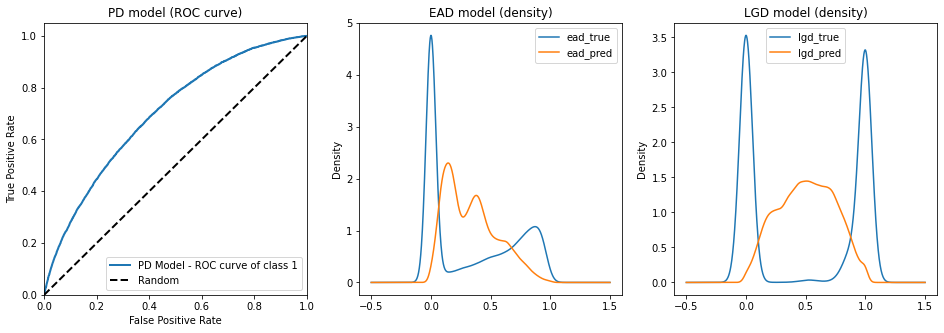

In [28]:
import scikitplot as skplt

f,ax = plt.subplots(1,3,figsize=(16,5))
skplt.metrics.plot_roc(y_test_pd, pipe_execution_pd.predict_proba(x_test_pd), plot_micro=False,plot_macro=False,classes_to_plot=1, ax=ax[0])
ax[0].get_lines()[0].set_color("C0")
ax[0].legend(labels = ['PD Model - ROC curve of class 1','Random'])
ax[0].set_title('PD model (ROC curve)')
pd.DataFrame({'ead_true':y_test_ead, 'ead_pred':pred_test_ead}).plot.density(title='EAD model (density)', ax=ax[1]);
pd.DataFrame({'lgd_true':y_test_lgd, 'lgd_pred':pred_test_lgd}).plot.density(title='LGD model (density)', ax=ax[2]);

- It is verified that there are no errors when introducing new data to the developed models.

- It is verified that the performance of the models with new data remains stable and similar to that obtained with the training data.